# Show Case Project 

*** 

## Microsoft Scholarship Foundation Course  

## Project: Chest X-Ray classification for COVID-19/Pneumonia detection 
***


This project has been attempted in order to participate in the optional showcase competetion held during the Microsoft Scholarship Foundation Course nanodegree at Udacity. This Jupyter Notebook explains the important steps.
***

## Step 1: Import Necessary Libararies 

In [1]:
import os # used in determining working directory 
import numpy as np 
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt                        
%matplotlib inline      


## Step 2: Unzip database.zip 

Database.zip has the training, validation and testing chest X-ray images. The following script was used to unzip the images. This script needs to be executed only once and is commented after executing the first time  

In [2]:
# import zipfile
# with zipfile.ZipFile("/home/workspace/covid-19/covid_database.zip","r") as zip_ref:
#     zip_ref.extractall("/home/workspace/covid-19")

# Step 3: Define data transformation and data loaders

The images have been resized to 224x224 RGB 

In [3]:

data_dir =  os.getcwd()
train_dir = os.path.join(data_dir, 'database/train/')
test_dir = os.path.join(data_dir, 'database/test/')
valid_dir = os.path.join(data_dir, 'database/valid/')

data_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)
valid_data = datasets.ImageFolder(valid_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))
print('Num validation images: ', len(valid_data))

print(train_dir)

Num training images:  2124
Num test images:  936
Num validation images:  33
/home/waqas/Desktop/showcase_project/3_classes/database/train/


In [4]:
# define dataloader parameters
batch_size = 20
num_workers=0
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

loaders_combined= {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

classes = ['COVID', 'NORMAL','PNEUMONIA']

# Step 4: Display one batch from the data loader

torch.Size([3, 224, 224])


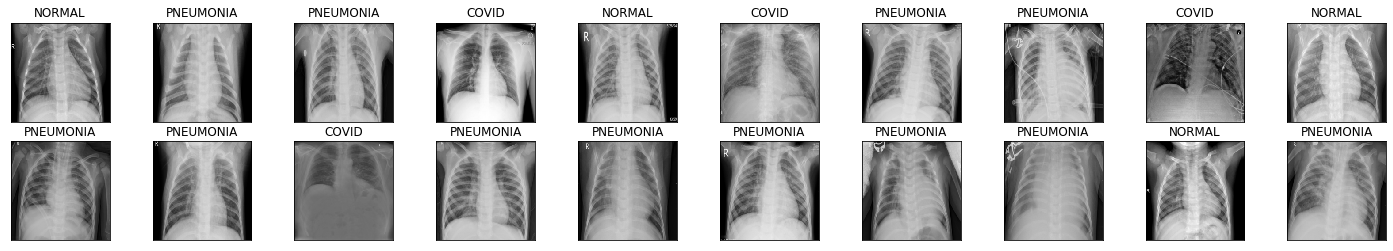

In [5]:

import torchvision
data_iter = iter(test_loader)
images, labels = next(data_iter)

print(images[0].shape) # Display the dimensions of image

images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])



# Step 5 : Define Model 

In [6]:

# check if CUDA is available
use_cuda = torch.cuda.is_available()
num_classes =3

import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # pool
        self.pool = nn.MaxPool2d(2, 2)
        
        # fully-connected
        self.fc1 = nn.Linear(7*7*128, 500)
        self.fc2 = nn.Linear(500, num_classes) 
        
        # drop-out
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        
        # flatten
        x = x.view(-1, 7*7*128)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = self.fc2(x)
        return x



# instantiate the CNN
model= Net()
print(model)

# move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


#  Step 6: Analyse Model 

In [7]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
         MaxPool2d-2           [-1, 32, 56, 56]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
         MaxPool2d-4           [-1, 64, 14, 14]               0
            Conv2d-5          [-1, 128, 14, 14]          73,856
         MaxPool2d-6            [-1, 128, 7, 7]               0
           Dropout-7                 [-1, 6272]               0
            Linear-8                  [-1, 500]       3,136,500
           Dropout-9                  [-1, 500]               0
           Linear-10                    [-1, 3]           1,503
Total params: 3,231,251
Trainable params: 3,231,251
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 4.60
Params size (MB): 12.33
Estima

# Step 7: Define Optimizer and Loss Function 

You can also define hyperparameters here 

In [8]:
### Loss function 
criterion = nn.CrossEntropyLoss()

### Optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.05)


# Step 8: Define Training Loop and Train 

In [9]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    valid_loss_min = 0.034831
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            #train_loss += loss.item()*data.size(0)
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 40 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # Print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## Save the model if validation loss has decreased
        
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    
            
    # return trained model
    return model




In [10]:

# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_scratch.pt'))

# # train the model
model = train(1, loaders_combined, model, optimizer, 
                       criterion, use_cuda, 'model_scratch.pt')

Epoch 1, Batch 1 loss: 0.008533
Epoch 1, Batch 41 loss: 0.044927
Epoch 1, Batch 81 loss: 0.040030
Epoch: 1 	Training Loss: 0.041951 	Validation Loss: 0.034831
Validation loss decreased (0.042356 --> 0.034831).  Saving model ...


# Step 9: Test Model  

In [11]:
model.load_state_dict(torch.load('model_scratch.pt'))
check = [0,0,0] # For the 3 classes, will contain number of correct predictions 
check_t = [0,0,0] # Total samples for three classes 

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))
    check = [0,0,0]
    check_t = [0,0,0]
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        for i in range(len(target)):
            check[target[i]]+= (target[i] == pred[i])
            check_t[target[i]]+= 1
        
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    


    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
#     print(check)
#     print(check_t)
    
    correct_pred=check[0].numpy() # Correct number of predictions
    total_samples=check_t[0] # Total samples for that class 
    temp=round(correct_pred[0]/total_samples,2) # percentage correctly predicted
    my_string="Accuracy for {} Chest X-Rays {}%, {}/{}".format(classes[0], str(temp*100),correct_pred[0],total_samples)
    print(my_string)
    
    correct_pred=check[1].numpy()
    total_samples=check_t[1]
    temp=round(correct_pred[0]/total_samples,2)
    my_string="Accuracy for {} Chest X-Rays {}%, {}/{}".format(classes[1], str(temp*100),correct_pred[0],total_samples)
    print(my_string)
    
    correct_pred=check[2].numpy()
    total_samples=check_t[2]
    temp=round(correct_pred[0]/total_samples,2)
    my_string="Accuracy for {} Chest X-Rays {}%, {}/{}".format(classes[2], str(temp*100),correct_pred[0],total_samples)
    print(my_string)
    


# call test function    
test(loaders_combined, model, criterion, use_cuda)

Test Loss: 0.427482


Test Accuracy: 87% (819/936)
Accuracy for COVID Chest X-Rays 95.0%, 175/184
Accuracy for NORMAL Chest X-Rays 76.0%, 276/362
Accuracy for PNEUMONIA Chest X-Rays 94.0%, 368/390


# Step 10: Display predictions along with original class 

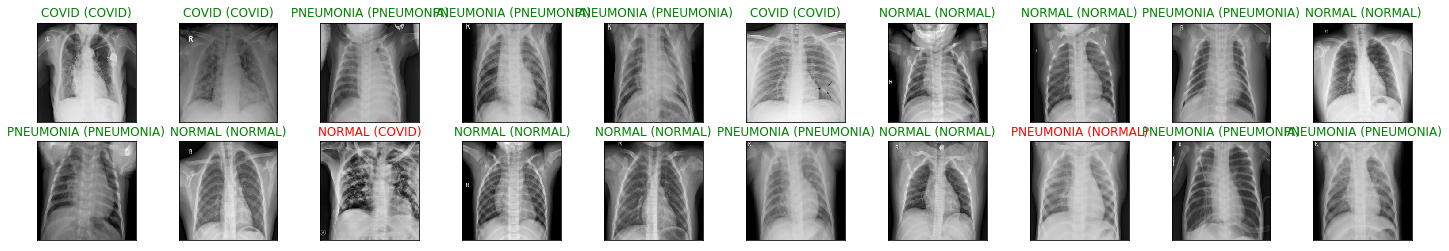

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()
# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tenspreds_tensor.numpy())
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
    color=("green" if preds[idx]==labels[idx].item() else "red"))

# Step Optional : Display Python version and other dependencies 
The following script lists the version of the python torch and other dependencies. This information was used during the deployment of the model. 

In [13]:
print(torch.__version__)
import sys
print(sys.version)

import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
list(imports())

1.4.0
3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


['builtins',
 'builtins',
 'os',
 'numpy',
 'torch',
 'torchvision.datasets',
 'torchvision.transforms',
 'torch.nn',
 'torch.nn.functional',
 'torch.optim',
 'matplotlib.pyplot',
 'torchvision',
 'sys',
 'types']

# Step Optional : Save all files in the directory into a Zip 

In [14]:
# import os
# cwd = os.getcwd()
# print(cwd)
# import shutil
# shutil.make_archive('database.zip', 'zip', '/home/workspace/covid-19/')